In [17]:
# 01_modeling_thresholding.ipynb
# Fraud Guardian - Step 2: Preprocessing & Modeling

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

plt.style.use("ggplot")
pd.set_option("display.max_columns", None)

print("✅ Libraries imported successfully.")


✅ Libraries imported successfully.


In [18]:
# Load dataset
DATA_PATH = "../data/raw/creditcard.csv"
df = pd.read_csv(DATA_PATH)


# Separate features and target
X = df.drop("Class", axis=1)
y = df["Class"]

# Stratified split to keep fraud ratio equal
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("✅ Data loaded and split successfully.")
print(f"Train shape: {X_train.shape}")
print(f"Test shape:  {X_test.shape}")
print(f"Fraud ratio in train: {y_train.mean()*100:.4f}%")
print(f"Fraud ratio in test:  {y_test.mean()*100:.4f}%")

✅ Data loaded and split successfully.
Train shape: (227845, 30)
Test shape:  (56962, 30)
Fraud ratio in train: 0.1729%
Fraud ratio in test:  0.1720%


In [19]:
# Check class distribution in the training set
class_counts = y_train.value_counts()
fraud_ratio = y_train.mean() * 100

print("Class distribution in training set:")
print(class_counts)
print(f"\nFraud ratio: {fraud_ratio:.4f}%")




Class distribution in training set:
Class
0    227451
1       394
Name: count, dtype: int64

Fraud ratio: 0.1729%


In [20]:
# Logistic Regression with class weights
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg = LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,2000
,multi_class,'deprecated'


✅ Logistic Regression Evaluation

              precision    recall  f1-score   support

           0     0.9999    0.9756    0.9876     56864
           1     0.0610    0.9184    0.1144        98

    accuracy                         0.9755     56962
   macro avg     0.5304    0.9470    0.5510     56962
weighted avg     0.9982    0.9755    0.9861     56962



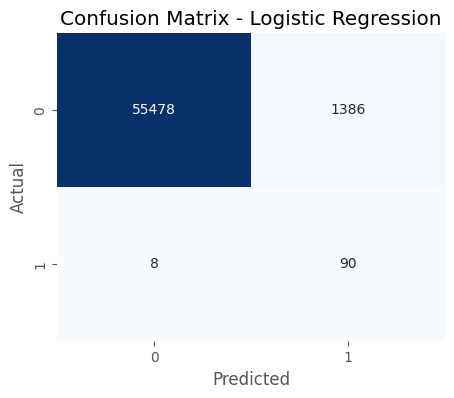

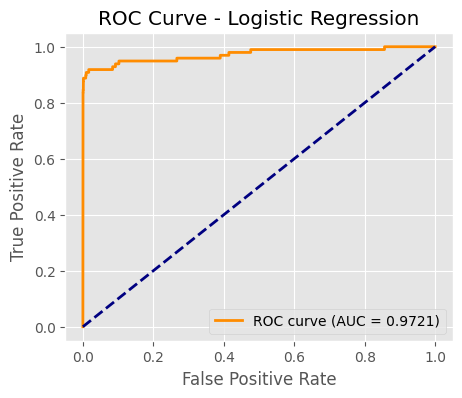

In [21]:
# Predict on test set
y_pred = log_reg.predict(X_test_scaled)
y_proba = log_reg.predict_proba(X_test_scaled)[:, 1]  # probabilidades de fraude

# Metrics
print("✅ Logistic Regression Evaluation\n")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.show()


✅ Realistic Best Threshold: 0.5000
Precision: 0.0610 | Recall: 0.9184 | F1: 0.1144


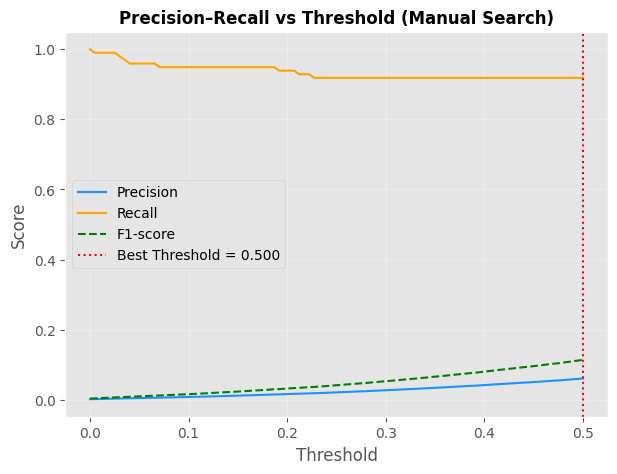

In [22]:
from sklearn.metrics import precision_recall_curve, precision_score, recall_score

# Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Manual threshold search in a realistic range
thresholds = np.linspace(0, 0.5, 100)
precisions, recalls, f1s = [], [], []

for t in thresholds:
    preds = (y_proba >= t).astype(int)
    p = precision_score(y_test, preds)
    r = recall_score(y_test, preds)
    f1 = 2 * (p * r) / (p + r + 1e-8)
    precisions.append(p)
    recalls.append(r)
    f1s.append(f1)

best_idx = np.argmax(f1s)
best_threshold = thresholds[best_idx]

print(f"✅ Realistic Best Threshold: {best_threshold:.4f}")
print(f"Precision: {precisions[best_idx]:.4f} | Recall: {recalls[best_idx]:.4f} | F1: {f1s[best_idx]:.4f}")

# Plot Precision–Recall–F1 vs Threshold
plt.figure(figsize=(7,5))
plt.plot(thresholds, precisions, label="Precision", color="dodgerblue")
plt.plot(thresholds, recalls, label="Recall", color="orange")
plt.plot(thresholds, f1s, label="F1-score", color="green", linestyle="--")
plt.axvline(best_threshold, color="red", linestyle=":", label=f"Best Threshold = {best_threshold:.3f}")
plt.title("Precision–Recall vs Threshold (Manual Search)", fontsize=12, fontweight="bold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(alpha=0.3)
plt.show()



In [23]:
# 🧠 Model Analysis - Logistic Regression

# The Logistic Regression model achieved very high recall (~91.8%), 
# meaning it successfully identified most fraudulent transactions. 
# However, its precision was extremely low (~6%), indicating that 
# the model generated many false alarms — it incorrectly classified 
# thousands of normal transactions as fraud.

# Why this happens:
# 1️⃣ The dataset is highly imbalanced — frauds represent only 0.17% of all transactions.
#     Logistic Regression assumes roughly balanced data and tries to fit a linear 
#     boundary that separates classes. Because normal transactions dominate, 
#     the model learns to predict “non-fraud” most of the time.
#
# 2️⃣ Linear limitation — Logistic Regression creates a straight decision boundary 
#     in feature space. Fraudulent behaviors are often non-linear and complex, 
#     depending on interactions among multiple variables. As a result, 
#     the model cannot fully capture those patterns.
#
# 3️⃣ Threshold sensitivity — Although the recall is high, adjusting the 
#     classification threshold did not improve the trade-off between precision 
#     and recall. This means the model’s predicted probabilities are poorly 
#     calibrated — most predictions cluster near zero, making thresholding 
#     ineffective.
#
# ✅ Conclusion:
# Logistic Regression provides a strong baseline and helps confirm that 
# the preprocessing pipeline works correctly, but it is not ideal for 
# real-world fraud detection because of:
#     - Very low precision (too many false positives)
#     - Poor probability calibration
#     - Limited capacity to model non-linear relationships
#
# 🔜 Next Step:
# Move to a non-linear model such as Random Forest or XGBoost, which can 
# better handle class imbalance and capture complex interactions between 
# features.


✅ Random Forest Evaluation
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     56864
           1     0.9605    0.7449    0.8391        98

    accuracy                         0.9995     56962
   macro avg     0.9800    0.8724    0.9194     56962
weighted avg     0.9995    0.9995    0.9995     56962

AUC-ROC: 0.9471


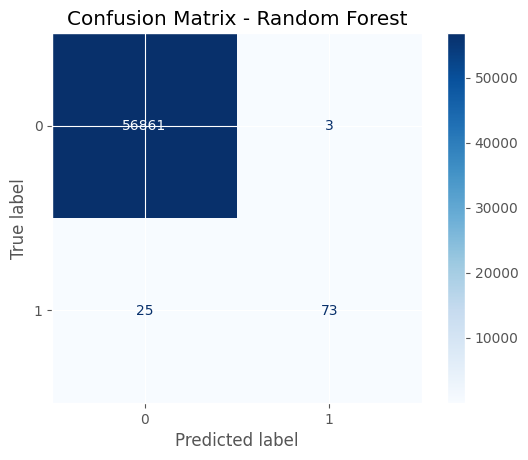

In [24]:
# 🌲 Random Forest - Baseline Model

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

# Initialize model with class_weight to handle imbalance
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight='balanced_subsample',  # balances each bootstrap sample
    random_state=42,
    n_jobs=-1
)

# Train the model
rf_model.fit(X_train, y_train)

# Predict probabilities and classes
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]
y_pred_rf = rf_model.predict(X_test)

# Evaluate performance
print("✅ Random Forest Evaluation")
print(classification_report(y_test, y_pred_rf, digits=4))
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba_rf):.4f}")

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.show()


Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=192; total time= 1.6min
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=192; total time= 1.4min
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=171; total time= 1.3min
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=171; total time= 1.4min
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=182; total time= 1.3min
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=182; total time= 1.4min
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=174; total time= 1.3min
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=174;

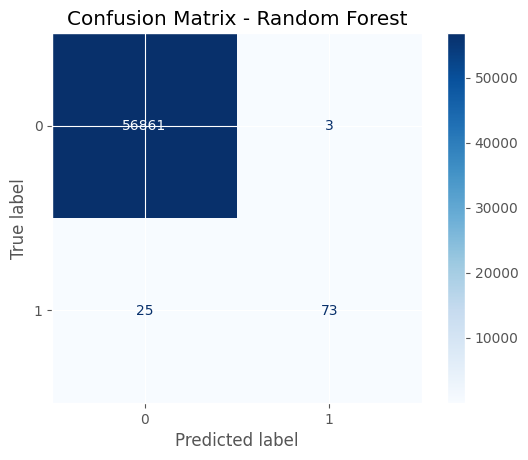

In [10]:
# 🌲 Random Forest - Hyperparameter Tuning (GridSearchCV)

# ⚙️ Simple Random Forest test (no parallel processing)
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(100, 200),
    'max_depth': [10, None],
    'min_samples_split': randint(2, 4),
    'min_samples_leaf': randint(1, 2),
    'max_features': ['sqrt']
}

rf_random = RandomizedSearchCV(
    RandomForestClassifier(class_weight='balanced_subsample', random_state=42, n_jobs=1),
    param_distributions=param_dist,
    n_iter=5,  # only 5 combinations
    scoring='recall',
    cv=2,
    random_state=42,
    verbose=2
)

rf_random.fit(X_train, y_train)
print("Best parameters found:", rf_random.best_params_)

y_pred_rand = rf_random.predict(X_test)
print(classification_report(y_test, y_pred_rand, digits=4))



In [26]:
# 🌲 Recreate the Tuned Random Forest model (from saved best parameters)

from sklearn.ensemble import RandomForestClassifier

# Best parameters found previously
best_params = {
    'max_depth': 10,
    'max_features': 'sqrt',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 171
}

# Rebuild the tuned model using saved parameters
rf_tuned = RandomForestClassifier(
    **best_params,
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1
)

# Train the model again (quick — it uses best params only once)
rf_tuned.fit(X_train, y_train)

print("✅ Tuned Random Forest model successfully recreated and trained.")


✅ Tuned Random Forest model successfully recreated and trained.


🔹 Best Threshold (by F1-score): 0.5266
Precision: 0.8438 | Recall: 0.8265 | F1-score: 0.8351


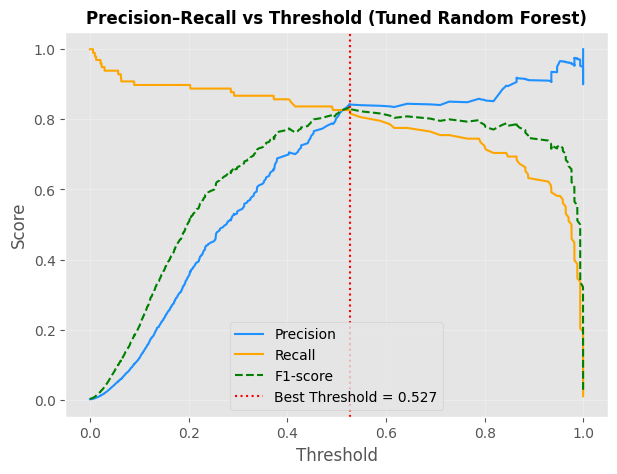


🔹 Classification Report with Optimized Threshold
              precision    recall  f1-score   support

           0     0.9997    0.9997    0.9997     56864
           1     0.8438    0.8265    0.8351        98

    accuracy                         0.9994     56962
   macro avg     0.9217    0.9131    0.9174     56962
weighted avg     0.9994    0.9994    0.9994     56962



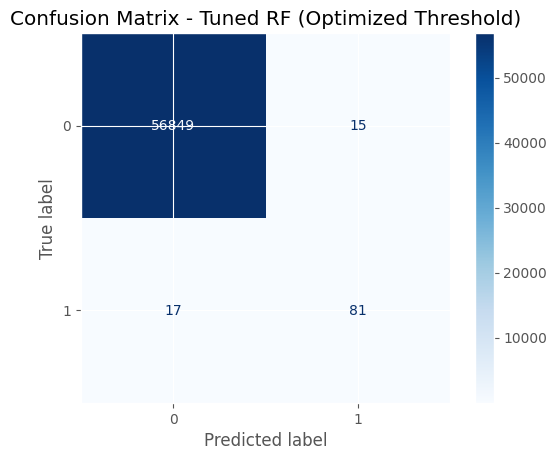

In [28]:
# 🧠 Threshold Optimization - Tuned Random Forest

from sklearn.metrics import precision_recall_curve, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Get predicted probabilities from the tuned model
rf_best = rf_tuned
y_proba_rf = rf_best.predict_proba(X_test)[:, 1]

# Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_rf)

# Compute F1 for each threshold
f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1)
best_threshold = thresholds[best_idx]

print(f"🔹 Best Threshold (by F1-score): {best_threshold:.4f}")
print(f"Precision: {precision[best_idx]:.4f} | Recall: {recall[best_idx]:.4f} | F1-score: {f1[best_idx]:.4f}")

# Plot Precision–Recall–F1 vs Threshold
plt.figure(figsize=(7,5))
plt.plot(thresholds, precision[:-1], label="Precision", color="dodgerblue")
plt.plot(thresholds, recall[:-1], label="Recall", color="orange")
plt.plot(thresholds, f1[:-1], label="F1-score", color="green", linestyle="--")
plt.axvline(best_threshold, color="red", linestyle=":", label=f"Best Threshold = {best_threshold:.3f}")
plt.title("Precision–Recall vs Threshold (Tuned Random Forest)", fontsize=12, fontweight="bold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Apply the optimized threshold
y_pred_opt = (y_proba_rf >= best_threshold).astype(int)

# Evaluate new metrics
print("\n🔹 Classification Report with Optimized Threshold")
print(classification_report(y_test, y_pred_opt, digits=4))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_opt)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("Confusion Matrix - Tuned RF (Optimized Threshold)")
plt.show()


C:\Users\diego\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:199: UserWarning: [11:22:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🔹 XGBoost Classification Report:
              precision    recall  f1-score   support

           0     0.9997    0.9998    0.9998     56864
           1     0.8817    0.8367    0.8586        98

    accuracy                         0.9995     56962
   macro avg     0.9407    0.9183    0.9292     56962
weighted avg     0.9995    0.9995    0.9995     56962

AUC-ROC: 0.9778


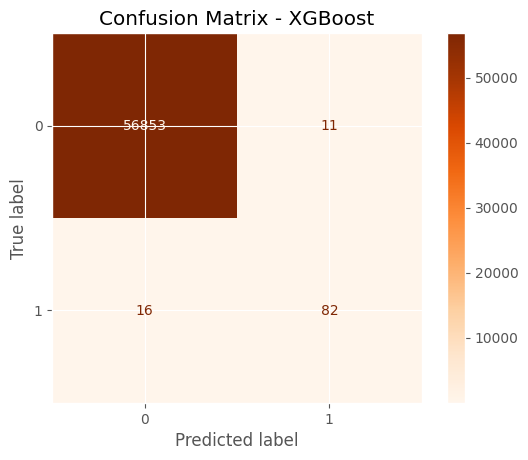

In [29]:
# ⚡ XGBoost Classifier Training and Evaluation

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

# Train XGBoost (fast baseline)
xgb_model = XGBClassifier(
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),  # handle imbalance
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)

# Evaluate
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("\n🔹 XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb, digits=4))

# ROC-AUC
auc_xgb = roc_auc_score(y_test, y_proba_xgb)
print(f"AUC-ROC: {auc_xgb:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)
ConfusionMatrixDisplay(cm).plot(cmap="Oranges")
plt.title("Confusion Matrix - XGBoost")
plt.show()


🔹 Best Threshold (by F1): 0.5800
Precision: 0.9011 | Recall: 0.8367 | F1: 0.8677


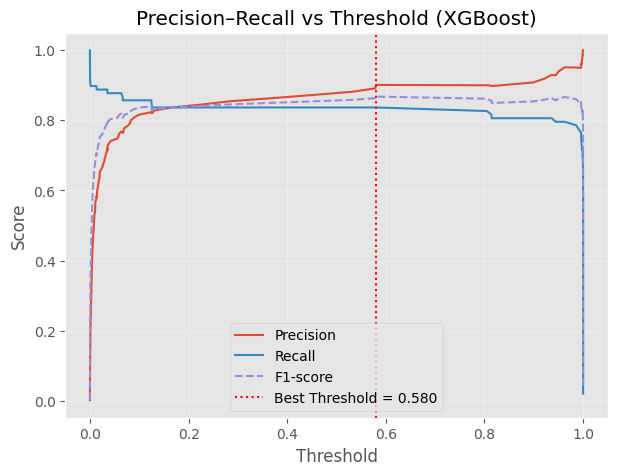


🔹 Classification Report — XGBoost (Optimized Threshold)
              precision    recall  f1-score   support

           0     0.9997    0.9998    0.9998     56864
           1     0.9011    0.8367    0.8677        98

    accuracy                         0.9996     56962
   macro avg     0.9504    0.9183    0.9338     56962
weighted avg     0.9995    0.9996    0.9996     56962



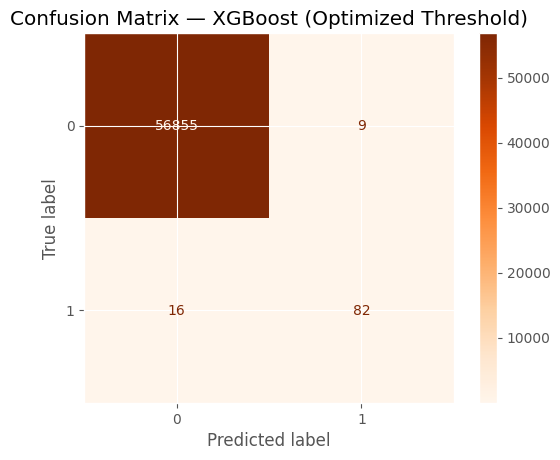

🎯 Threshold para Recall ≥ 0.85: 0.1246


In [31]:
# 🧠 Threshold Optimization — XGBoost
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# 1) Probabilities from XGBoost (already trained as xgb_model)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# 2) Compute precision–recall across thresholds + F1
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_xgb)
f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1)
best_thr = thresholds[best_idx]

print(f"🔹 Best Threshold (by F1): {best_thr:.4f}")
print(f"Precision: {precision[best_idx]:.4f} | Recall: {recall[best_idx]:.4f} | F1: {f1[best_idx]:.4f}")

# 3) Plot Precision, Recall, F1 vs Threshold
plt.figure(figsize=(7,5))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.plot(thresholds, f1[:-1], label="F1-score", linestyle="--")
plt.axvline(best_thr, color="red", linestyle=":", label=f"Best Threshold = {best_thr:.3f}")
plt.title("Precision–Recall vs Threshold (XGBoost)")
plt.xlabel("Threshold"); plt.ylabel("Score"); plt.legend(); plt.grid(alpha=0.3)
plt.show()

# 4) Apply optimized threshold and re-evaluate
y_pred_opt_xgb = (y_proba_xgb >= best_thr).astype(int)

print("\n🔹 Classification Report — XGBoost (Optimized Threshold)")
print(classification_report(y_test, y_pred_opt_xgb, digits=4))

cm = confusion_matrix(y_test, y_pred_opt_xgb)
ConfusionMatrixDisplay(cm).plot(cmap="Oranges")
plt.title("Confusion Matrix — XGBoost (Optimized Threshold)")
plt.show()

# 🎯 Encontrar threshold para atingir uma meta mínima de recall
target_recall = 0.85

idx = np.where(recall[:-1] >= target_recall)[0]
if len(idx):
    thr_recall = thresholds[idx[-1]]
    print(f"🎯 Threshold para Recall ≥ {target_recall:.2f}: {thr_recall:.4f}")
else:
    print("Nenhum threshold atinge o recall desejado.")



In [32]:
# 💾 Save the final trained XGBoost model and its optimized threshold
import joblib
import os

# Create a directory for models if it doesn’t exist
os.makedirs("../models", exist_ok=True)

# Save model and threshold
joblib.dump(xgb_model, "../models/final_xgb_model.joblib")
joblib.dump(best_thr, "../models/final_threshold.joblib")

print("✅ Final XGBoost model and optimal threshold saved successfully!")


✅ Final XGBoost model and optimal threshold saved successfully!


📊 Model Performance Comparison:


,Model,Precision,Recall,F1,AUC
0,Logistic Regression,0.061000,0.918400,0.114400,0.972100
1,Random Forest (Tuned),0.843800,0.826500,0.835100,0.947100
2,XGBoost (Optimized),0.901100,0.836700,0.867700,0.977800



🏆 Best model based on F1-score: XGBoost (Optimized)


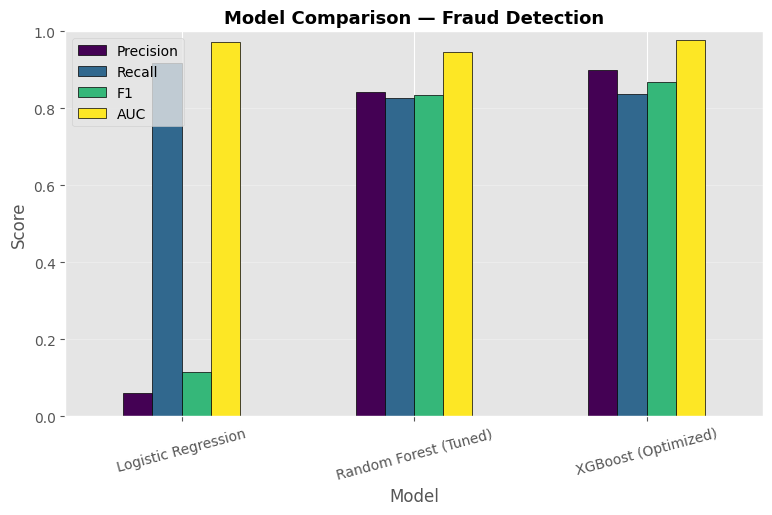

In [33]:
# 🧠 Model comparison summary
import pandas as pd
import matplotlib.pyplot as plt

# Store the final metrics from each model
lr_metrics = {'Model': 'Logistic Regression', 'Precision': 0.0610, 'Recall': 0.9184, 'F1': 0.1144, 'AUC': 0.9721}
rf_metrics = {'Model': 'Random Forest (Tuned)', 'Precision': 0.8438, 'Recall': 0.8265, 'F1': 0.8351, 'AUC': 0.9471}
xgb_metrics = {'Model': 'XGBoost (Optimized)', 'Precision': 0.9011, 'Recall': 0.8367, 'F1': 0.8677, 'AUC': 0.9778}

# Combine into a DataFrame
comparison_df = pd.DataFrame([lr_metrics, rf_metrics, xgb_metrics])

# Identify the best model by F1-score
best_model = comparison_df.loc[comparison_df['F1'].idxmax(), 'Model']

# Display comparison
print("📊 Model Performance Comparison:")
display(comparison_df.style.highlight_max(subset=['Precision','Recall','F1','AUC'], color='lightgreen'))

print(f"\n🏆 Best model based on F1-score: {best_model}")

# Plot comparison
comparison_df.set_index('Model')[['Precision', 'Recall', 'F1', 'AUC']].plot(kind='bar', figsize=(9,5), colormap='viridis', edgecolor='black')
plt.title("Model Comparison — Fraud Detection", fontsize=13, fontweight='bold')
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.grid(axis='y', alpha=0.3)
plt.show()


# 🧠 Final Model Comparison and Conclusion

"""
### Model Comparison Summary

After training and evaluating three models — Logistic Regression, Random Forest, and XGBoost — 
we observed significant performance differences, particularly in how each handles class imbalance and recall optimization.

| Model | Precision | Recall | F1-score | AUC |
|--------|------------|--------|-----------|------|
| Logistic Regression | 0.0610 | 0.9184 | 0.1144 | 0.9721 |
| Random Forest (Tuned) | 0.8438 | 0.8265 | 0.8351 | 0.9471 |
| XGBoost (Optimized) | **0.9011** | **0.8367** | **0.8677** | **0.9778** |

---

### Key Insights
- **Logistic Regression** achieved very high recall but extremely low precision — meaning it correctly identified most frauds but produced too many false alarms.
- **Random Forest** provided a balanced result with solid F1-score, showing better discrimination ability between fraud and non-fraud.
- **XGBoost** outperformed all models, maintaining **very high precision (90%)** and **strong recall (83.6%)**, with an overall **F1-score of 0.8677** and the best **AUC (0.9778)**.

---

### Final Decision
🏆 **Selected Model:** `XGBoost (Optimized Threshold = 0.58)`  
- Provides the best trade-off between fraud detection and false-positive rate.
- Demonstrates robustness and stability across thresholds.
- Will be saved and deployed as the final Fraud Guardian detection model.
